## Cosmos. ATOM Analysis

In [1]:
import pandas as pd
import numpy as np
import json
from math import log10

from src.utils_bigquery import create_table_from_df, drop_table
from src.utils_charts import grade_boundaries_analysis
from config import COSMOS_DATASET_NAME, COSMOS_DISTRIBUTION_TABLE_NAME

DROP_TABLES = True
CREATE_TABLES = True

### Load Cosmos Snapshot

In [2]:
with open("data/cosmos_genesis_snapshot.json") as f:
    cosmos_genesis_snapshot = json.load(f)

### Get Balances from the Snapshot

In [3]:
def get_atoms(coins):
    for coin in coins:
        if coin['denom']=='uatom':
            return float(coin['amount'])/1e6
    return 0

balances_df = pd.DataFrame(cosmos_genesis_snapshot["app_state"]['bank']['balances'])
balances_df.loc[:, 'balance_atom'] = balances_df.coins.map(get_atoms)

balances_atom_df = balances_df[balances_df.balance_atom != 0].copy()
balances_atom_df.loc[:, 'balance_atom_rounded'] = balances_atom_df.balance_atom.map(lambda x: round(x + 0.05, 1))

balances_atom_agg_df = balances_atom_df.groupby('balance_atom_rounded')['address'].agg([('number_of_addresses', np.count_nonzero)]).reset_index()

### Analysis of Grade Boundaries. Atom Owners

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,0 < Fee spending to created contracts <= 35.0,126318,89.1
2,35.0 < Fee spending to created contracts <= 11...,14093,9.9
3,1143.0 < Fee spending to created contracts,1418,1.0


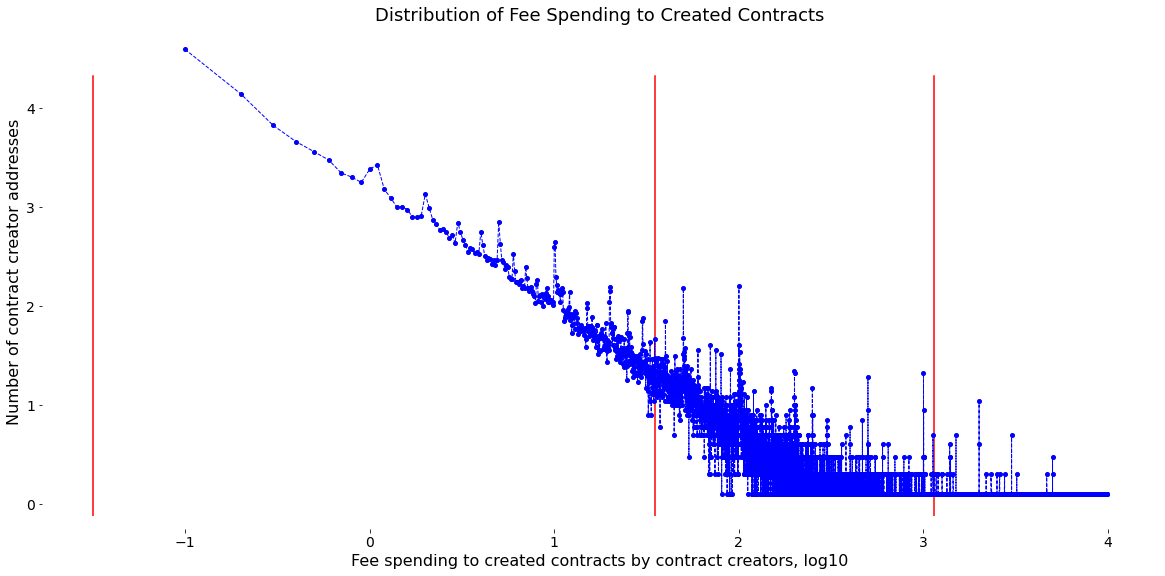

In [4]:
atom_owners_boundary =\
    grade_boundaries_analysis(
        distribution_df=balances_atom_agg_df,
        value_column='balance_atom_rounded',
        address_column='number_of_addresses',
        address_chart_label='Number of contract creator addresses',
        value_chart_label='Fee spending to created contracts by contract creators, log10',
        value_name='Fee spending to created contracts',
        value_transform_func=lambda x: log10(x) if x > 0 else -1.5,
        chart_title='Distribution of Fee Spending to Created Contracts',
        max_show_value=10000,
        initial_boundary=0,
        level_line_shift=0,
        boundary_round=0)

### Distribution Rule. Atom Owners

<table style="text-align: center">
    <thead>
        <tr>
            <th rowspan=2> </th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> ATOM Balance </td>
            <td> > 0 ATOM </td>
            <td> > 35 ATOM </td>
            <td> > 1143 ATOM </td>
        </tr>
    </tbody>
</table>


### Create Distribution Table

In [5]:
def set_grade(x):
    if x > atom_owners_boundary[2]:
        return 3
    elif x > atom_owners_boundary[1]:
        return 2
    elif x > atom_owners_boundary[0]:
        return 1
    return None

balances_atom_df.loc[:,'grade'] = balances_atom_df['balance_atom'].map(set_grade)

In [6]:
if CREATE_TABLES:
    create_table_from_df(source_df=balances_atom_df[['address', 'grade']],
                         table_name=COSMOS_DISTRIBUTION_TABLE_NAME,
                         dataset_name=COSMOS_DATASET_NAME,
                         drop_existing_table=DROP_TABLES)
elif DROP_TABLES:
    drop_table(table_name=COSMOS_DISTRIBUTION_TABLE_NAME,
               dataset_name=COSMOS_DATASET_NAME)

Table cosmos:cosmos_distribution has been deleted.
